In [1]:
#pip install -e .

In [1]:
import gym
import gym_teen
import numpy as np
import time
import sys
import math
import random
from matplotlib import pyplot as plt

In [2]:
def get_explore_rate(t,min_explore_rate,decay_fact):
    return max(min_explore_rate, min(0.8, 1.0 - math.log10((t+1)/decay_fact)))


def get_learning_rate(t,min_learning_rate,decay_fact):
    return max(min_learning_rate, min(0.8, 1.0 - math.log10((t+1)/decay_fact)))

In [3]:
# variables: 
neps = 20
tstep = 200
min_explore_rate = 0.001
min_learning_rate = 0.2
#grid_size = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
#decay_fact = np.prod(grid_size, dtype=float) / 10.0
decay_fact = np.prod((405,405),dtype=float)/10.0
#state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
explore_rate = get_explore_rate(0,min_explore_rate,decay_fact)
learning_rate = get_learning_rate(0,min_learning_rate,decay_fact)

In [4]:
max_t = np.prod((405,405),dtype=int)*100
streak_to_end = 100
solved_t = np.prod((405,405),dtype=int)


In [5]:
def select_action(env,state, q_table,explore_rate):
    # Select a random action
    if random.random() < explore_rate:
        action = env.action_space.sample()
    # Select the action with the highest q
    else:
        action = int(np.argmax(q_table[state]))
    return action

In [6]:
def state_to_bucket(state,env):
    grid_size = tuple((env.observation_space.high + np.ones(env.observation_space.shape)).astype(int))
    state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
    bucket_indice = []
    for i in range(len(state)):
        if state[i] <= state_bounds[i][0]:
            bucket_index = 0
        elif state[i] >= state_bounds[i][1]:
            bucket_index = grid_size[i] - 1
        else:
            # Mapping the state bounds to the bucket array
            bound_width = state_bounds[i][1] - state_bounds[i][0]
            offset = (grid_size[i]-1)*state_bounds[i][0]/bound_width
            scaling = (grid_size[i]-1)/bound_width
            bucket_index = int(round(scaling*state[i] - offset))
        bucket_indice.append(bucket_index)
    return tuple(bucket_indice)

In [7]:
def run_qlearn(env,q_table, explore_rate, learning_rate, neps=200,tstep=100):
    env.render()
    num_streaks = 0
    discount_factor = 0.99
    max_t = np.prod((405,405),dtype=int)*100
    streak_to_end = 100
    solved_t = np.prod((405,405),dtype=int)
    decay_fact = np.prod((405,405),dtype=float)/10.0

    t_steps = []
    episodes = []
    reward_at_episode = []
    
    for ep in range(neps):
        if ep == 0:
            time.sleep(1)
        obv = env.reset()
        print('------------'+str(ep))
        state_0 = state_to_bucket(obv,env)
        total_reward = 0
        
        for t in range(tstep):
            # select best action and execute
            action = select_action(env,state_0, q_table, explore_rate)
            try: 
                obv,reward,done,_ = env.step(action)
            except(IndexError):
                print(action)
                print(state_0)
                break
            
            # update the state you are in, add reward (observe result)
            state = state_to_bucket(obv,env)
            total_reward += reward
            #print(reward)
            #print('cur' + str(reward))
            #print(total_reward)
            #print(reward, total_reward)
            
            # update Q-table
            best_q = np.amax(q_table[state])
            q_table[state_0 + (action,)] += learning_rate * (reward + discount_factor * (best_q) - q_table[state_0 + (action,)])
            
            # update state
            state_0 = state
            
            env.render()
            #time.sleep(0.0000001)
            
            
            # update parameters
            #explore_rate = get_explore_rate(ep,min_explore_rate,decay_fact)
            #learning_rate = get_learning_rate(ep,min_learning_rate,decay_fact)
            
            if done:
                time.sleep(1)
                print("Episode %d finished after %f time steps with total reward = %f (streak %d)."
                      % (ep, t, total_reward, num_streaks))
                t_steps.append(t)
                episodes.append(ep)
                reward_at_episode.append(total_reward)
    

                if t <= solved_t:
                    num_streaks += 1
                else:
                    num_streaks = 0
                break

            elif t >= max_t - 1:
                print("Episode %d timed out at %d with total reward = %f."
                      % (ep, t, total_reward))
                    


        # It's considered done when it's solved over 120 times consecutively
        if num_streaks > streak_to_end:
            break
            
        explore_rate = get_explore_rate(ep,0.001,decay_fact)
        learning_rate = get_learning_rate(ep,0.2,decay_fact)
                
    return q_table, t_steps, episodes, reward_at_episode

In [8]:
q_table0 = np.zeros((405,405) + (4,), dtype=float)
env1=gym.make('maze-v0',height=60,width=60)

pygame 2.1.2 (SDL 2.0.18, Python 3.7.12)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [10]:

fin_q_table, time_steps, episode, max_reward_at_episode = run_qlearn(env1,q_table0,explore_rate,learning_rate,neps=100,tstep=max_t)

------------0
Episode 0 finished after 60.000000 time steps with total reward = -5153.516268 (streak 0).
------------1
Episode 1 finished after 2.000000 time steps with total reward = -142.287978 (streak 1).
------------2
Episode 2 finished after 0.000000 time steps with total reward = 1.000000 (streak 2).
------------3
Episode 3 finished after 483.000000 time steps with total reward = -44274.659244 (streak 3).
------------4
3
(0, 0)
------------5
Episode 5 finished after 80.000000 time steps with total reward = -6732.185086 (streak 4).
------------6
Episode 6 finished after 0.000000 time steps with total reward = 1.000000 (streak 5).
------------7
Episode 7 finished after 0.000000 time steps with total reward = 1.000000 (streak 6).
------------8
Episode 8 finished after 1.000000 time steps with total reward = -85.682372 (streak 7).
------------9
0
(0, 0)
------------10
2
(0, 0)
------------11
0
(0, 0)
------------12
Episode 12 finished after 459.000000 time steps with total reward = -

KeyboardInterrupt: 

Text(0, 0.5, '# of Time Steps')

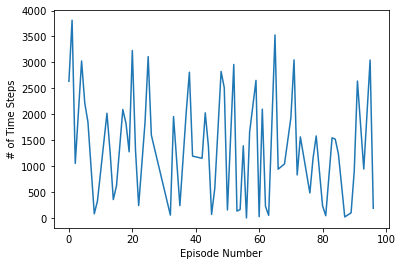

In [17]:
plt.plot(episode, time_steps)
plt.xlabel("Episode Number")
plt.ylabel("# of Time Steps")

Text(0, 0.5, 'Max Reward')

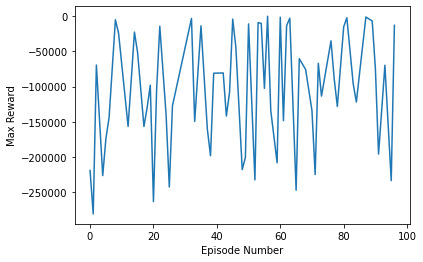

In [18]:
plt.plot(episode, max_reward_at_episode)
plt.xlabel("Episode Number")
plt.ylabel("Max Reward")

# Deep RL Keras

In [13]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Convolution2D
from tensorflow.keras.optimizers import Adam
from rl.agents import DQNAgent

# knowledge buffer from previous games
from rl.memory import SequentialMemory

# Greedy is what allows us to find the best outcome, Linear is what allows us to optimize the strategy. 
from rl.policy import LinearAnnealedPolicy, EpsGreedyQPolicy

In [15]:
# takes in the states from our environment, and the actions from our environment. 
# number of frames or instances in the input. 
def build_model(height, width, channels, actions, window_length):
    model = Sequential()

    # 3 convolutional layers. 
    model.add(Convolution2D(32,(8,8),strides=(4,4), activation='relu', input_shape=(window_length,height,width, channels)))
    model.add(Convolution2D(64,(4,4),strides=(2,2), activation='relu'))
    model.add(Convolution2D(64,(3,3), activation='relu'))
    model.add(Flatten())

    # 3 dense layers
    model.add(Dense(512, activation = 'relu'))
    model.add(Dense(256, activation = 'relu'))
    # takes image to an output of actions. 
    model.add(Dense(actions, activations='linear'))
    return model

In [16]:
def build_agent(model, actions, window_length2):
    policy = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=1., value_min=.1, value_test=.2, nb_steps=10000)
    memory = SequentialMemory(limit=1000, window_length=window_length2)
    dqn = DQNAgent(model=model, memory=memory, policy=policy,
                  enable_dueling_network=True, dueling_type='avg', 
                   nb_actions=actions, nb_steps_warmup=1000
                  )
    return dqn

In [22]:
env = gym.make('Ant-v2')


DependencyNotInstalled: No module named 'mujoco_py'. (HINT: you need to install mujoco_py, and also perform the setup instructions here: https://github.com/openai/mujoco-py/.)

In [18]:
actions = env1.action_space.n
print(actions)

4


In [19]:
print( env1.observation_space.shape)

(2,)


In [ ]:
 model = build_model(height, width, channels, actions)

In [13]:
#height, width, channels = env1.observation_space.shape
print( env1.observation_space.shape)
#print(height, width, channels)
actions = env1.action_space.n
print(env1.unwrapped.get_action_mearnings())
print(actions)

(2,)


AttributeError: 'MazeEnvSample5x5' object has no attribute 'get_action_mearnings'

In [1]:
import gym
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
from util import plot_learning_curve

In [2]:
class LinearDeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, input_dims):
        super(LinearDeepQNetwork, self).__init__()

        self.fc1 = nn.Linear(*input_dims, 128)
        self.fc2 = nn.Linear(128, n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        layer1 = F.relu(self.fc1(state))
        actions = self.fc2(layer1)

        return actions


class Agent():
    def __init__(self, input_dims, n_actions, lr, gamma=0.99,
                 epsilon=1.0, eps_dec=1e-5, eps_min=0.01):
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_dec = eps_dec
        self.eps_min = eps_min
        self.action_space = [i for i in range(self.n_actions)]

        self.Q = LinearDeepQNetwork(self.lr, self.n_actions, self.input_dims)

    def choose_action(self, observation):
        if np.random.random() > self.epsilon:
            state = T.tensor(observation, dtype=T.float).to(self.Q.device)
            actions = self.Q.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                        if self.epsilon > self.eps_min else self.eps_min

    def learn(self, state, action, reward, state_):
        self.Q.optimizer.zero_grad()
        states = T.tensor(state, dtype=T.float).to(self.Q.device)
        actions = T.tensor(action).to(self.Q.device)
        rewards = T.tensor(reward).to(self.Q.device)
        states_ = T.tensor(state_, dtype=T.float).to(self.Q.device)

        q_pred = self.Q.forward(states)[actions]

        q_next = self.Q.forward(states_).max()

        q_target = rewards + self.gamma*q_next

        loss = self.Q.loss(q_target, q_pred).to(self.Q.device)
        loss.backward()
        self.Q.optimizer.step()
        self.decrement_epsilon()

In [3]:
env = gym.make('CartPole-v1')
n_games = 10000
scores = []
eps_history = []

agent = Agent(lr=0.0001, input_dims=env.observation_space.shape,
                n_actions=env.action_space.n)

for i in range(n_games):
    score = 0
    done = False
    obs = env.reset()

    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        print(obs.shape)
        print(obs)
        score += reward
        agent.learn(obs, action, reward, obs_)
        obs = obs_
    scores.append(score)
    eps_history.append(agent.epsilon)

    if i % 100 == 0:
        avg_score = np.mean(scores[-100:])
        print('episode ', i, 'score %.1f avg score %.1f epsilon %.2f' %
                (score, avg_score, agent.epsilon))
filename = 'cartpole_naive_dqn.png'
x = [i+1 for i in range(n_games)]
plot_learning_curve(x, scores, eps_history, filename)

(4,)
[ 0.02877766 -0.04060693  0.0088831   0.02894154]
(4,)
[ 0.02796553  0.1543865   0.00946193 -0.26092547]
(4,)
[ 0.03105326  0.34937212  0.00424342 -0.55060905]
(4,)
[ 0.0380407   0.15419082 -0.00676876 -0.25659218]
(4,)
[ 0.04112452 -0.04083383 -0.01190061  0.03394811]
(4,)
[ 0.04030784 -0.23578313 -0.01122164  0.32285264]
(4,)
[ 0.03559218 -0.4307435  -0.00476459  0.61197567]
(4,)
[ 0.02697731 -0.6257985   0.00747492  0.90315413]
(4,)
[ 0.01446134 -0.43077862  0.02553801  0.61283004]
(4,)
[ 0.00584576 -0.23602271  0.03779461  0.3282988 ]
(4,)
[ 0.00112531 -0.43166175  0.04436058  0.6326568 ]
(4,)
[-0.00750793 -0.6273736   0.05701372  0.9389735 ]
(4,)
[-0.0200554  -0.4330647   0.07579319  0.6647366 ]
(4,)
[-0.02871669 -0.2390743   0.08908792  0.39684832]
(4,)
[-0.03349818 -0.4353398   0.09702489  0.7162363 ]
(4,)
[-0.04220498 -0.2416851   0.11134961  0.45560104]
(4,)
[-0.04703868 -0.04829913  0.12046164  0.1999877 ]
(4,)
[-0.04800466  0.14491242  0.12446139 -0.05239927]
(4,)
[-0.0

KeyboardInterrupt: 